# Qermit Tutorial

Qermit is a package for performing error mitigation on quantum circuits. This is *not* the same as fault tolerance. Fault tolerance involes correcting qubits on-the-go with other qubits -- typically hundreds of 'physical' qubits are required for one, error-corrected 'logical' qubit.

Error mitigation involves techniques to minimise the noise you get when using near-term, noisy devices. 

For more information, see the [Qermit paper](https://arxiv.org/abs/2204.09725) and the [Qermit user manual](https://cqcl.github.io/Qermit/manual/index.html). The information here is more or less a streamlined subset of the information in the manual -- there's much more detail in there.

To get started, run `pip install qermit`.

This tutorial will get through:
- [MitRes in Qermit](#MitRes-in-Qermit)
- [SPAM mitigation](#SPAM-mitigation)

## Import packages

In [14]:
from pytket import Circuit
from pytket.extensions.qiskit import AerBackend
from pytket.circuit.display import render_circuit_jupyter as rcj
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider

from utils.utils import plot_bars, plot_multiple_bars, tuple_to_ket, gen_tuples

In [15]:
provider = IBMProvider()

## Define noiseless and noisy backends

In [16]:
# Aer backend with no noise
aer_backend_no_noise = AerBackend()

# Aer backend with noise model from real device
device_backend = provider.get_backend('ibm_lagos')
noise_model = NoiseModel.from_backend(device_backend)
noisy_aer_backend = AerBackend(noise_model=noise_model)

## Define a circuit

In [17]:
n_qubits = 5
c = Circuit(n_qubits)

# Prepare ghz state
c.H(0).CX(0, 1).CX(1, 2).CX(2, 3).CX(3, 4).measure_all()
rcj(c)

As a comparison, we'll run the same circuit on a noiseless simulator, a noisy simulator, and a noisy simulator with error mitigation applied.

## Execute on noiseless Aer backend

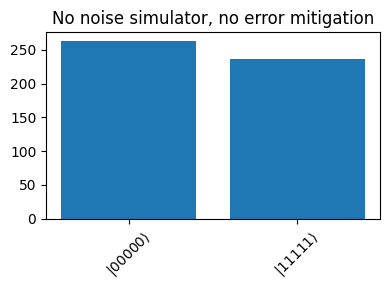

In [18]:
c_compiled = aer_backend_no_noise.get_compiled_circuit(c)
handle = aer_backend_no_noise.process_circuit(c_compiled, n_shots=500)
result = aer_backend_no_noise.get_result(handle)
counts_no_noise = result.get_counts()

plot_bars(counts_no_noise, "No noise simulator, no error mitigation", x_tick_labels=[tuple_to_ket(x) for x in counts_no_noise.keys()]);

Counter({(0, 0, 0, 0, 0): 230, (1, 1, 1, 1, 1): 228, (0, 1, 1, 1, 1): 8, (0, 0, 0, 1, 0): 6, (0, 0, 0, 0, 1): 4, (1, 0, 0, 0, 0): 4, (1, 1, 0, 1, 1): 4, (0, 0, 1, 0, 0): 3, (0, 1, 0, 0, 0): 3, (1, 0, 1, 1, 1): 3, (1, 1, 1, 0, 1): 3, (1, 1, 1, 1, 0): 2, (1, 0, 1, 0, 1): 1, (1, 1, 1, 0, 0): 1})


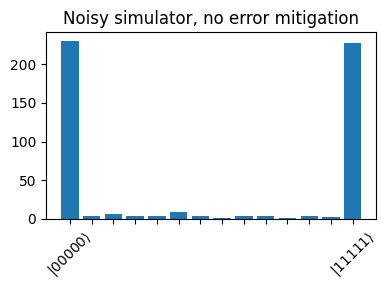

In [19]:
# Execute on noisy simulator
c_c = noisy_aer_backend.get_compiled_circuit(c)
h = noisy_aer_backend.process_circuit(c_c, n_shots=500)
r = noisy_aer_backend.get_result(h)
cs_noise = r.get_counts()
print(cs_noise)
plot_bars(cs_noise, "Noisy simulator, no error mitigation", x_tick_labels=[tuple_to_ket(x) for x in cs_noise.keys()]);

## Using MitRes in Qermit

Qermit is based on task graphs which show the pipeline of processes which will take place. This should be familiar from the [tket example notebook](pytket_tutorial.ipynb).

For a normal, non-error mitigated circuit, the task graph involves:
1. Compile to fit the backend
2. Execute on the backend, returning handles
3. Use handles to get results

The task graph can be extended with various error mitigation methods.

To start off, let's look at the basic task graph which compiles the circuit and returns results from handles as usual:

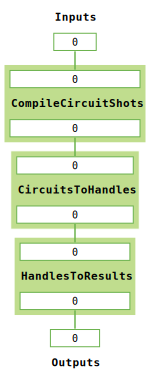

In [20]:
from qermit.taskgraph import gen_compiled_MitRes

basic_mitres = gen_compiled_MitRes(backend=noisy_aer_backend)
basic_mitres.get_task_graph()

Calling `.run` on a `MitRes` object makes it go through and perform all the actions in the task graph.

`.run` must be performed on a list of `CircuitShots` objects.

In [21]:
from qermit import CircuitShots

# Have a look at the CircuitShots object
print(CircuitShots(Circuit=c, Shots=50))

CircuitShots(Circuit=[H q[0]; CX q[0], q[1]; Measure q[0] --> c[0]; CX q[1], q[2]; Measure q[1] --> c[1]; CX q[2], q[3]; Measure q[2] --> c[2]; CX q[3], q[4]; Measure q[3] --> c[3]; Measure q[4] --> c[4]; ], Shots=50)


Now let's run a simple example by running the task graph on the `CircuitShots`:

In [22]:
example_experiment = [CircuitShots(Circuit=c, Shots=50)]
results = basic_mitres.run(example_experiment)
print(results[0].get_counts())

Counter({(1, 1, 1, 1, 1): 24, (0, 0, 0, 0, 0): 16, (0, 1, 0, 0, 0): 2, (0, 1, 1, 1, 0): 2, (1, 1, 1, 1, 0): 2, (0, 0, 0, 1, 0): 1, (1, 0, 0, 0, 0): 1, (1, 1, 0, 0, 0): 1, (1, 1, 0, 1, 1): 1})


## SPAM Mitigation

SPAM stands for State Preparation and Measurement, and it's an important source of error in quantum circuits. SPAM mitigation works by repeatedly preparing and mreasuring a basis state to get an idea of the error in the preparation and measurement.

Let's have a look at the task graph for SPAM mitigation:

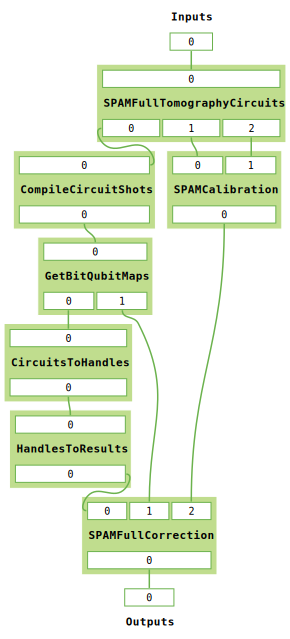

In [23]:
from qermit.spam import gen_UnCorrelated_SPAM_MitRes

# The 'uncorrelated' here means the qubit errors are assumed to be 
# independent of each other.
# This might not be true! -- see the manual for other options.

spam_mitres = gen_UnCorrelated_SPAM_MitRes(
    backend=noisy_aer_backend,
    calibration_shots=500
)
spam_mitres.get_task_graph()

Now let's compare two sets of results -- one using the basic `MitRes` graph with no error mitigation, and one using the SPAM mitigation task grpah.

In [24]:
noisy_experiment = [CircuitShots(Circuit=c, Shots=500)]
noisy_results = basic_mitres.run(noisy_experiment)

noisy_counts = noisy_results[0].get_counts()

In [25]:
spam_mitigated_mitres = spam_mitres.run(noisy_experiment)
mitigated_counts = spam_mitigated_mitres[0].get_counts()


Now let's look at the results. Since this is a Bell test, we know what ideal results should look like: an exact 50/50 split between the two all-0s and all-1s states. We'll use this as a comparison

In [26]:
ideal_counts = {(0, 0, 0, 0, 0): 250, (1, 1, 1, 1, 1): 250}

We'll plot:
- Those 'ideal' results
- Results on the noisy device
- Results using SPAM mitigation

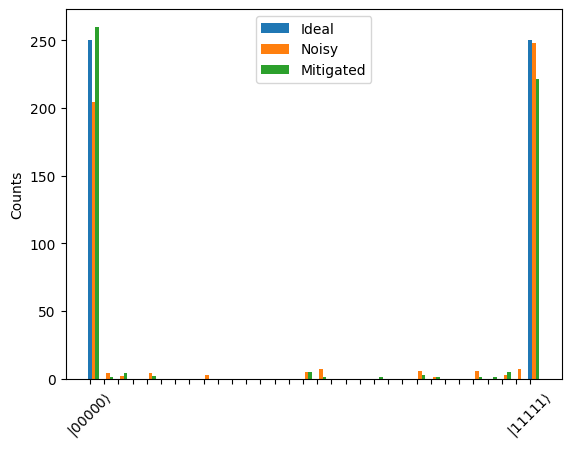

In [27]:
plot_multiple_bars([ideal_counts, noisy_counts, mitigated_counts,], ['Ideal', 'Noisy', 'Mitigated'])

### Error mitigation with multiple circuits

Doing the same error mitigation with multiple circuits works in exactly the same way -- you just need to pass a list of `CircuitShots` objects instead of a single one:

In [28]:
lots_of_circuits = [c.copy() for _ in range(10)]

lots_of_circuits_noisy_experiment = [CircuitShots(Circuit=ci, Shots=500) for ci in lots_of_circuits]
lots_of_circuits_noisy_results = basic_mitres.run(lots_of_circuits_noisy_experiment)

lots_of_circuits_counts = [r.get_counts() for r in lots_of_circuits_noisy_results]

# Print counts for the first circuit
print(lots_of_circuits_counts[0])

Counter({(0, 0, 0, 0, 0): 224, (1, 1, 1, 1, 1): 222, (0, 1, 1, 1, 1): 9, (1, 1, 1, 1, 0): 9, (1, 1, 0, 1, 1): 7, (0, 1, 0, 0, 0): 6, (1, 0, 0, 0, 0): 5, (0, 0, 0, 1, 0): 4, (0, 0, 0, 0, 1): 3, (1, 0, 1, 1, 1): 3, (1, 1, 1, 0, 1): 3, (0, 0, 1, 1, 1): 2, (1, 0, 1, 0, 1): 1, (1, 0, 1, 1, 0): 1, (1, 1, 0, 0, 1): 1})


### MitRes with Myqos

This works in a very similar way to before, just with a `MyqosBackend` rather than a tket one.

In [29]:
from pytket.extensions.myqos import Myqos, MyqosBackend, AerConfig, IBMQEmulatorConfig

myqos = Myqos()
myqos.login()

In [33]:
config = IBMQEmulatorConfig(backend_name='ibm_lagos', hub='YOUR HUB HERE', group='YOUR GROUP HERE', project='YOUR PROJECT HERE')

try:
    experiment = myqos.new_experiment('test')

except:
    experiment = myqos.get_experiment_by_name('test')

noisy_myqos_backend = MyqosBackend(config, experiment=experiment, remote=True)


Started using experiment with name: test


In [34]:
config = AerConfig()
backend = MyqosBackend(config)

In [35]:
myqos_spam_mitres = gen_UnCorrelated_SPAM_MitRes(
    backend=noisy_myqos_backend,
    calibration_shots=500
)

In [42]:
myqos_spam_experiment = [CircuitShots(Circuit=c, Shots=500)]

In [43]:
myqos_spam_results = myqos_spam_mitres.run(myqos_spam_experiment)

In [44]:
myqos_spam_counts = myqos_spam_results[0].get_counts()
print(myqos_spam_counts)

Counter({(1, 1, 1, 1, 1): 237, (0, 0, 0, 0, 0): 235, (0, 1, 0, 0, 0): 8, (1, 0, 1, 1, 1): 7, (0, 1, 1, 1, 1): 5, (0, 0, 1, 0, 0): 3, (1, 1, 0, 0, 0): 2, (1, 1, 1, 0, 0): 2, (0, 0, 1, 1, 1): 2, (0, 0, 0, 0, 1): 1, (1, 1, 1, 0, 1): 1, (0, 0, 0, 1, 1): 1})


## Zero noise extrapolation

The method above is concerned with mitigating the individual counts you get back from a quantum device.

However, we're often concerned with the expectation value of a particular observable, i.e. the average of the counts you get back from a quantum device.

The `MitEx` object in qermit can be used to perform error mitigation on the expectation values. 

Zero noise extrapolation (ZNE) is a nifty way of estimating noise-free expectation values. You can read more about it in [this paper](https://arxiv.org/abs/2005.10921).

It works by artificially _increasing_ the noise in the circuit, looking at how that affects the expectation values, then extrapolating back to the zero-noise case.

### Using MitEx

Similar to `MitRes`, `MitEx` has a task graph which can be extended with various error mitigation methods.

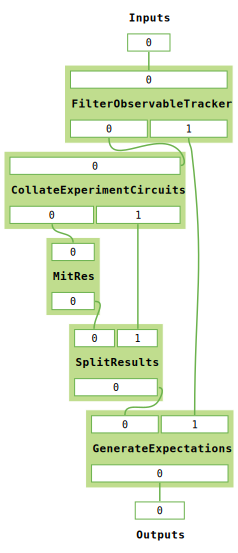

In [79]:
from qermit import MitEx
from pytket.extensions.qiskit import AerBackend, IBMQEmulatorBackend

noisy_backend = IBMQEmulatorBackend('ibm_lagos')

# mitex = MitEx(backend=AerBackend())
mitex = MitEx(backend=noisy_backend)
mitex.get_task_graph()

In order to run a circuit with `MitEx`, you first need to deal with a couple of things.

### Pauli operators

First, you need to define what observable you're going to measure. This is a `QubitPauliOperator`, which might consist of a number of `QubitPauliString`s. For example, you might be interested in expectation value of the operator:

$\^O = 0.5 X_0 Y_1 Z_2 - Z_0 Z_2$.

This would be respresented in python as:

```python
from pytket import Qubit
from pytket.pauli import QubitPauliOperator, QubitPauliString, Pauli

xyz = QubitPauliString({Qubit(0): Pauli.X, Qubit(1): Pauli.Y, Qubit(2): Pauli.Z})
zz = QubitPauliString({Qubit(0): Pauli.Z, Qubit(2): Pauli.Z})
op = QubitPauliOperator({xyz: 0.5, zz: 1.0})
```

If you wanted the Z expectation value for each individual qubit, you could use:
    
```python
strings = [QubitPauliString({Qubit(i): Pauli.Z}) for i in range(n_qubits)]
op = QubitPauliOperator({s: 1.0 for s in strings})
```
This is the one we'll use in the example below.

### Running an experiment

In order to run a `MitEx`, you define an `ObservableExperiment` which takes:
- An `AnsatzCircuit`. This takes:
  - A `Circuit`
  - The number of shots
  - A symbols dictionary for substituting in values for the symbols in the circuit
- An `ObservableTracker`
  - This takes the `QubitPauliOperator` you want to measure

Let's now run an experiment with `MitEx`, but not yet using any error mitigation.

We first need to define the `AnsatzCircuit`:

In [80]:
from qermit import AnsatzCircuit, SymbolsDict
from pytket.circuit import Circuit, Qubit

circuit = Circuit(3,3).X(0).X(1).Rz(0.5, 2)

# Define a deep circuit with Z expectation 1 for all qubits:
circuit = Circuit(3)
for i in range(10):
    circuit.Rz(0.5, 0).Rz(0.5, 1).Rz(0.5, 2)
    circuit.CX(0, 1).CX(1, 2).CX(2, 0)
    circuit.Rz(0.5, 0).Rz(0.5, 1).Rz(0.5, 2)
    circuit.CX(0, 1).CX(1, 2).CX(2, 0)
    circuit.Rz(0.5, 0).Rz(0.5, 1).Rz(0.5, 2)
    circuit.CX(0, 1).CX(1, 2).CX(2, 0)

# circuit.measure_all()

shots = 1000
symbols = SymbolsDict()  # We don't have any symbols in this circuit

ansatz_circuit = AnsatzCircuit(Circuit=circuit, Shots=shots, SymbolsDict=symbols)

And next the observable we're interested in and the `ObservableTracker`:

In [81]:
# Define the Pauli operator we're interested in:

from pytket import Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator

strings = [QubitPauliString([Qubit(i)], [Pauli.Z]) for i in range(3)]
operator = QubitPauliOperator({s: 1.0 for s in strings})

print(operator)

{(Zq[0]): 1.00000000000000, (Zq[1]): 1.00000000000000, (Zq[2]): 1.00000000000000}


In [82]:
from qermit import ObservableTracker

observable_tracker = ObservableTracker(operator)

Finally we give the `AnsatzCircuit` and the `ObservableTracker` to the experiment:

In [83]:
from qermit import ObservableExperiment

observable_experiment = ObservableExperiment(AnsatzCircuit=ansatz_circuit, ObservableTracker=observable_tracker)
print(observable_experiment)

ObservableExperiment(AnsatzCircuit=AnsatzCircuit(Circuit=[Rz(0.5) q[0]; Rz(0.5) q[1]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; CX q[2], q[0]; Rz(0.5) q[1]; Rz(0.5) q[0]; Rz(0.5) q[2]; CX q[0], q[1]; CX q[1], q[2]; 

In [84]:
results = mitex.run([observable_experiment])

In [85]:
results

[{(Zq[0]): 0.964000000000000, (Zq[1]): 0.966000000000000, (Zq[2]): 0.970000000000000}]